In [1]:
import pandas as pd
#conn_url = "postgresql://robot-startml-ro:pheiph0hahj1Vaif@"
conn_url = "<your_connection_url"
# чтение таблицы
post_text_df = pd.read_sql(
    "select * from public.post_text_df;",
    conn_url)
feed_data_df = pd.read_sql(
    'select * from public.feed_data limit 150000;',
    conn_url
)
user_data_df = pd.read_sql(
    'select * from public.user_data;',
    conn_url
)


In [3]:
feed_data_df.head()

,timestamp,user_id,post_id,action,target
0,2021-12-04 14:41:51,88665,5063,view,1
1,2021-12-04 14:44:35,88665,5063,like,0
2,2021-12-04 14:44:37,88665,5590,view,0
3,2021-12-04 14:47:01,88665,1531,view,0
4,2021-12-04 14:48:01,88665,6737,view,0


In [4]:
post_text_df.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [5]:
user_data_df.head()

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads


In [6]:
# Все юзеры уникальные 
user_data_df['user_id'].value_counts().sum()

163205

In [7]:
# Узнаем сколько разных юзеров на обучающих данных
feed_data_df['user_id'].nunique()

320

### Формирование полного датасета из таблиц про user, post, feed

In [2]:
# Соединим 3 наши таблицы в одную общую, на которой будем обучаться
feed_with_user = pd.merge(feed_data_df, user_data_df, on = 'user_id', how = 'inner')
data = pd.merge(feed_with_user, post_text_df, on = 'post_id', how = 'inner')
data.shape


(150000, 14)

In [3]:
data.set_index(['user_id', 'post_id'], inplace=True)

In [4]:
# Преобразуем признак timestamp в удобный для нас тип datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [5]:
# Отсортируем данные, чтобы не нарушить временную логику при обучении
data.sort_values(by = 'timestamp', inplace=True)

In [12]:
data.head()

timestamp action  target  gender  age     country  \
user_id post_id                                                               
136740  1960    2021-10-01 06:07:31   view       1       0   20  Kazakhstan   
        1960    2021-10-01 06:07:41   like       0       0   20  Kazakhstan   
        1452    2021-10-01 06:07:43   view       0       0   20  Kazakhstan   
        1604    2021-10-01 06:08:04   view       0       0   20  Kazakhstan   
2680    5321    2021-10-01 06:08:40   view       0       1   21      Russia   

                      city  exp_group       os   source  \
user_id post_id                                           
136740  1960     Türkistan          1      iOS  organic   
        1960     Türkistan          1      iOS  organic   
        1452     Türkistan          1      iOS  organic   
        1604     Türkistan          1      iOS  organic   
2680    5321        Abakan          0  Android      ads   

                                                              text  topic  
user_id post_id                                                            
136740  1960     Apple sues to stop product leaks\n\nComputer f...   tech  
        1960     Apple sues to stop product leaks\n\nComputer f...   tech  
        1452     Middlesbrough 2-2 Charlton\n\nA late header by...  sport  
        1604     Prutton poised for lengthy FA ban\n\nSouthampt...  sport  
2680    5321     all i can say about this film is to read the b...  movie

In [13]:
data.shape

(150000, 12)

### EDA Analysis

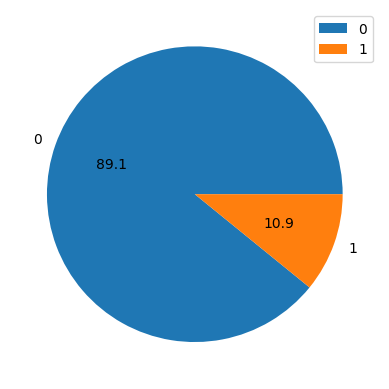

In [7]:
# Распределение таргета
import matplotlib.pyplot as plt
plt.pie(data['target'].value_counts(), labels = data['target'].value_counts().index, autopct = '%.1f')
plt.legend()
plt.show()


<Axes: >

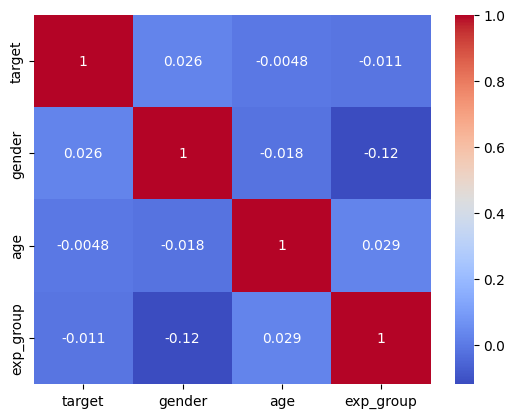

In [13]:
import seaborn as sns
corr_mtrx = data.corr()
sns.heatmap(corr_mtrx, annot = True, cmap = 'coolwarm')

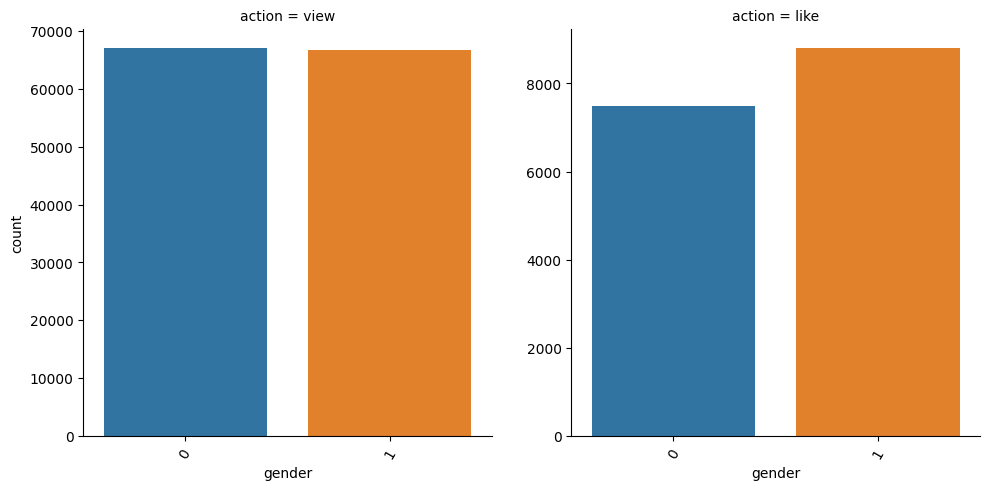

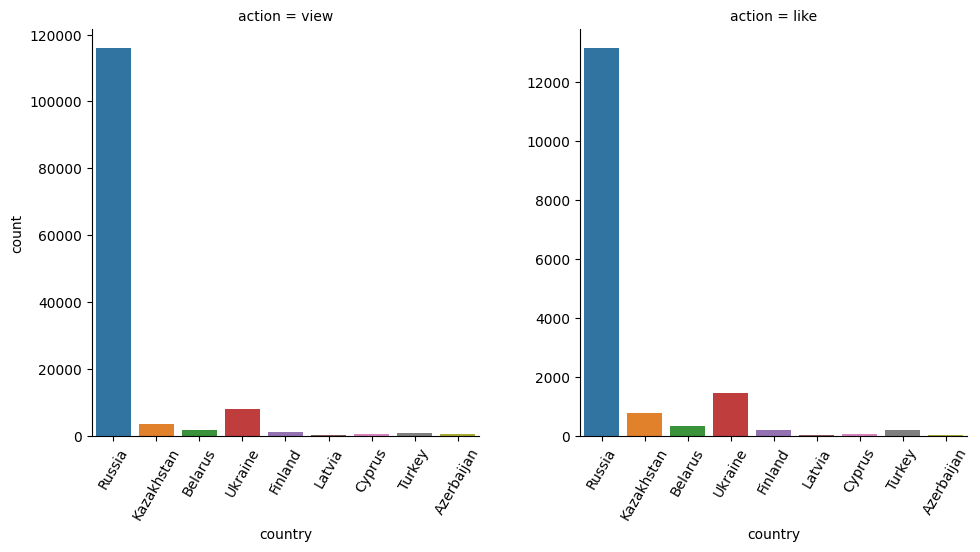

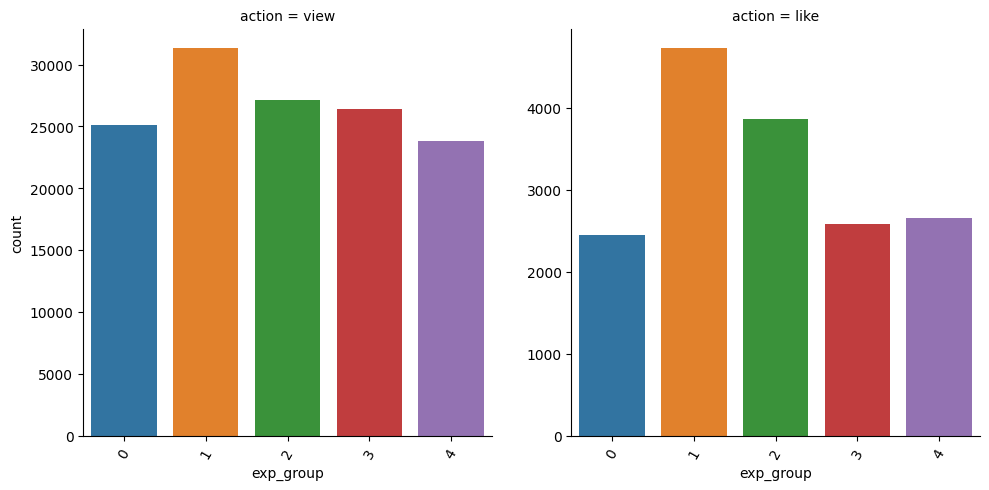

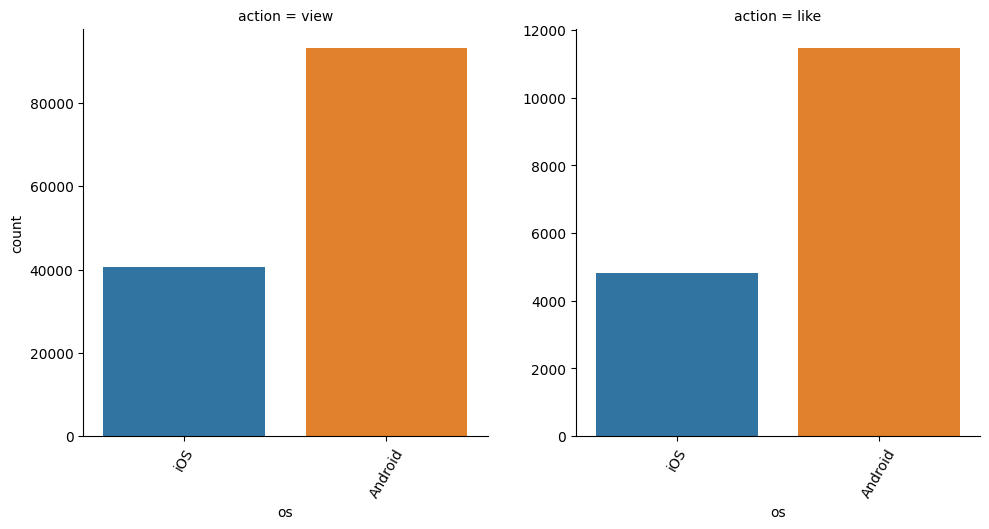

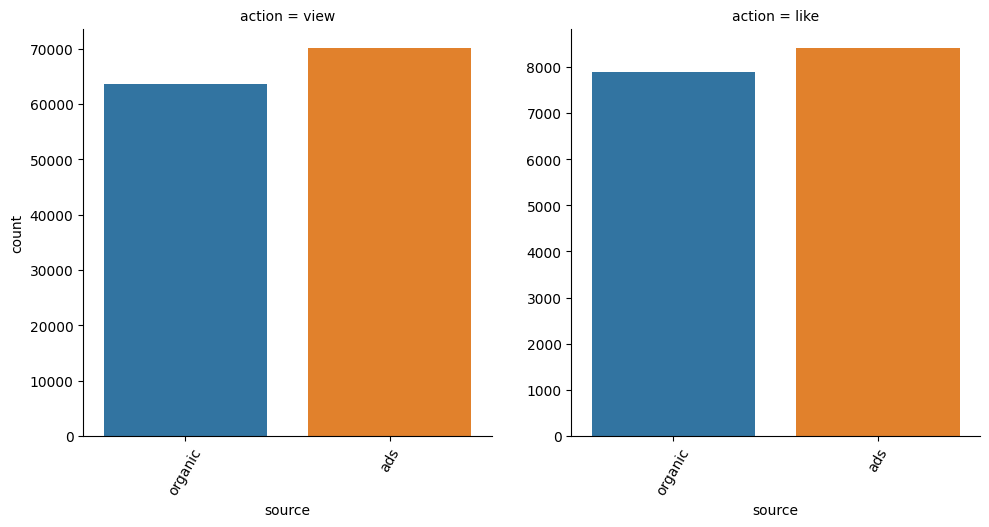

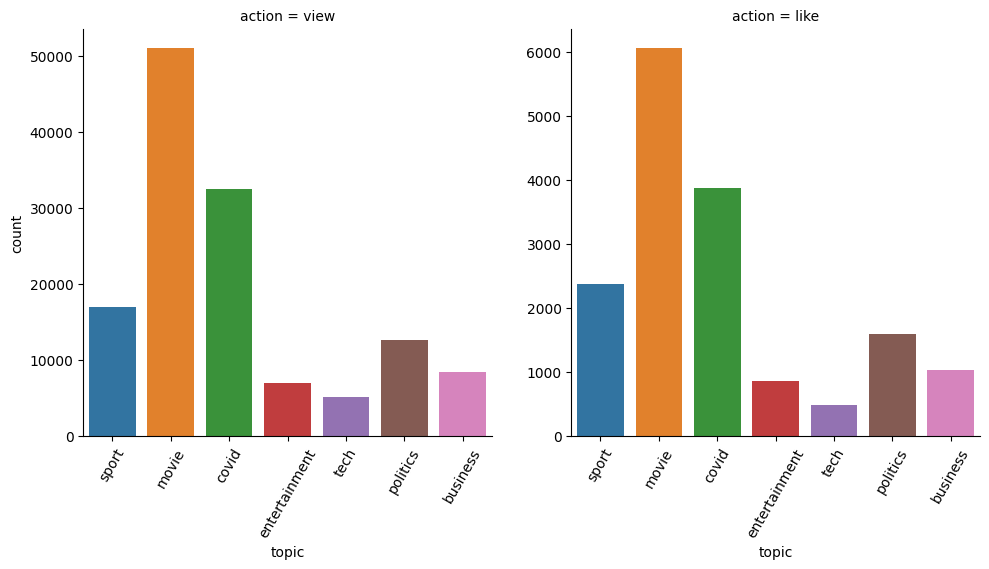

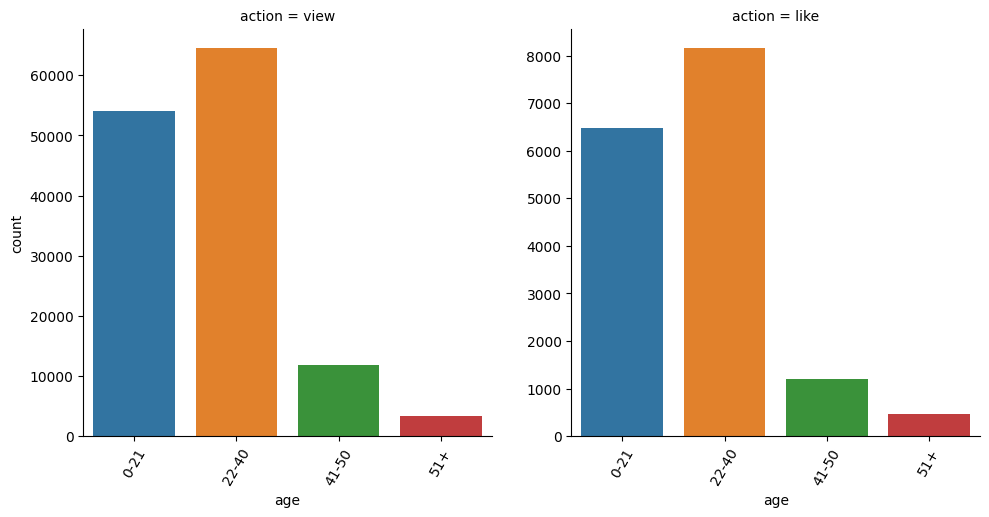

In [20]:
check_cols = ['gender', 'country', 'exp_group', 'os', 'source', 'topic', 'age']
for col in check_cols:
    if col == 'age':
        age_bins = [0, 21, 40, 50, float('inf')]
        age_labels = ['0-21', '22-40', '41-50', '51+']

        # Categorize the age values into the defined groups
        temp = data.copy()
        temp['age'] = pd.cut(temp['age'], bins=age_bins, labels=age_labels)
        cat_plt = sns.catplot(x=col, kind='count', col='action', data=temp, sharey=False)
        cat_plt.set_xticklabels(rotation=60)
    else:
        cat_plt = sns.catplot(x=col, kind='count', col='action', data=data, sharey=False)
        cat_plt.set_xticklabels(rotation=60)
plt.show()

### Разделим данные и создадим модель CatBoostClassifier

In [21]:
from sklearn.model_selection import train_test_split
X = data.drop(['target', 'text', 'action'], axis = 1)
y = data['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [22]:
X.head()

timestamp  gender  age country    city  exp_group  \
user_id post_id                                                               
136783  1507    2021-10-01 06:02:14       1   21  Russia   Ozëry          3   
        5769    2021-10-01 06:02:31       1   21  Russia   Ozëry          3   
        2770    2021-10-01 06:03:15       1   21  Russia   Ozëry          3   
        7042    2021-10-01 06:05:39       1   21  Russia   Ozëry          3   
116793  768     2021-10-01 06:07:20       1   38  Russia  Rostov          0   

                      os   source          topic  
user_id post_id                                   
136783  1507         iOS  organic          sport  
        5769         iOS  organic          movie  
        2770         iOS  organic          covid  
        7042         iOS  organic          movie  
116793  768      Android  organic  entertainment

In [23]:
print(y_train.value_counts())
print(y_test.value_counts())

0    107451
1     12549
Name: target, dtype: int64
0    26256
1     3744
Name: target, dtype: int64


In [24]:
# Отберем категориальные колонки для catboost classifier
cat_cols = X.describe(include = 'object').columns
cat_cols

Index(['country', 'city', 'os', 'source', 'topic'], dtype='object')

In [25]:
from catboost import CatBoostClassifier
model = CatBoostClassifier(eval_metric='AUC', verbose=20, iterations=100)
#model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, cat_features=list(cat_cols))

In [26]:
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, cat_features=list(cat_cols))

Learning rate set to 0.281493
0:	test: 0.5092845	best: 0.5092845 (0)	total: 232ms	remaining: 23s
20:	test: 0.6166108	best: 0.6166108 (20)	total: 1.44s	remaining: 5.4s
40:	test: 0.6168388	best: 0.6169501 (34)	total: 2.81s	remaining: 4.05s
60:	test: 0.6175618	best: 0.6189601 (49)	total: 4.25s	remaining: 2.71s
80:	test: 0.6154870	best: 0.6189601 (49)	total: 5.68s	remaining: 1.33s
99:	test: 0.6146949	best: 0.6189601 (49)	total: 7.11s	remaining: 0us

bestTest = 0.6189600853
bestIteration = 49

Shrink model to first 50 iterations.


### PR-кривая, PR-AUC

0.1780305595655421


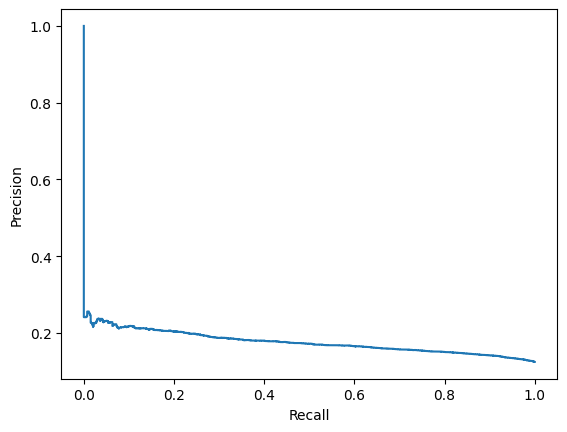

In [27]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay, auc

precision, recall, thresholds = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
PrecisionRecallDisplay(precision=precision, recall=recall).plot()
print(auc(recall, precision))


### Подсчет HitRate5

In [28]:
def hitrate5(model, X, Y):
    check = pd.concat([Y,
                       pd.Series(model.predict_proba(X)[:,1], index=Y.index, name='probas')],
                      axis=1)
    check = check.reset_index().drop(columns='post_id')
    
    pred_list = [check[check.user_id == user_id].sort_values('probas', ascending=False).iloc[:5]
                 for user_id in check.user_id.unique()]

    return pd.concat(pred_list).groupby('user_id').target.sum().map(lambda x: min(1, x)).mean()

print('Hitrate@5: {:.4f}'.format(hitrate5(model, X_test, y_test)))

Hitrate@5: 0.5740


### Сохраним датафрейм, на котором мы будем делать предсказания

In [32]:
topic = post_text_df['topic'].unique().tolist()
dataframe = user_data_df.copy()
topic_df = pd.DataFrame({'topic': topic})
dataframe = dataframe.merge(topic_df, how='cross')
dataframe.head()

,user_id,gender,age,country,city,exp_group,os,source,topic
0,200,1,34,Russia,Degtyarsk,3,Android,ads,business
1,200,1,34,Russia,Degtyarsk,3,Android,ads,covid
2,200,1,34,Russia,Degtyarsk,3,Android,ads,entertainment
3,200,1,34,Russia,Degtyarsk,3,Android,ads,sport
4,200,1,34,Russia,Degtyarsk,3,Android,ads,politics


In [119]:
dataframe.to_csv('dataframe.csv', index = False)

### Сохранение модели

In [ ]:
model.save_model('model', format = 'cbm')

### TEST

In [64]:
import pandas as pd
from catboost import CatBoostClassifier
model = CatBoostClassifier().load_model("<model_path>")
dataframe = pd.read_csv('dataframe.csv')

In [65]:
# Функция для рекомандации 5-ти постов
def rec_posts(time, user_id):
    df = dataframe[dataframe['user_id'] == user_id].copy()
    df['timestamp'] = time
    df['prob'] = model.predict_proba(df[model.feature_names_])[:, 1]
    mapping = {}
    for val in df['topic']:
        mapping[val] = df[df['topic'] == val].prob.values[0]
    post_text_df['prob'] = post_text_df['topic'].map(mapping)
    post_text_df.sort_values(by = 'prob', ascending=False, inplace=True)
    lst = post_text_df.head()[['post_id', 'text', 'topic']].values.tolist()
    result_list = [{'id': item[0], 'text': item[1], 'topic': item[2]} for item in lst]
    return result_list
    


In [66]:
from datetime import datetime
print(rec_posts(datetime(year = 2022, month = 1, day = 1, hour = 1), 137852))

[{'id': 2099, 'text': 'Britons growing digitally obese\n\nGadget lovers are so hungry for digital data many are carrying the equivalent of 10 trucks full of paper in weight.\n\nMusic, images, e-mails, and texts are being hoarded on mobiles, cameras laptops and PDAs (Personal Digital Assistants), a Toshiba study found. It found that more than 60% kept 1,000 to 2,000 music files on their devices, making the UK digitally fat. Virtual weight measurements are based on research by California Institute of Technology professor Roy Williams. He calculated physical comparisons for digital data in the mid-1990s. He worked out that one gigabyte (1,000,000,000 bytes) was the equivalent of a pick-up truck filled with paper. The amount of data people are squirreling away on their gadgets is clearly a sign that people are finding more things to do with their shiny things.\n\nIf digital hoarding habits continue on this scale, people could be carrying around a digitally obese 20 gigabytes by next year. 

In [56]:
post_text_df.head()

,post_id,text,topic,prob
2552,2070,Who do you think you are?\n\nThe real danger i...,tech,0.087881
2669,2160,Reboot ordered for EU patent law\n\nA European...,tech,0.087881
2863,2291,Ask Jeeves joins web log market\n\nAsk Jeeves ...,tech,0.087881
2670,2161,Game firm holds cast auditions\n\nVideo game f...,tech,0.087881
2823,2264,DVD copy protection strengthened\n\nDVDs will ...,tech,0.087881
